In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from uncertainties import *
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import unumpy

In [14]:
data = pd.read_csv("Data.csv", sep=",")

In [16]:
dh = abs(data.left - data.right)    #   Lower values correspond to higher water levels.

Q_1 = data.Volume_1/data.Time_1    # Q in cm^3 s^-1
Q_2 = data.Volume_2/data.Time_2    # pm 1 cm^3 for v, pm 0.50 s for t
Q_3 = data.Volume_3/data.Time_3

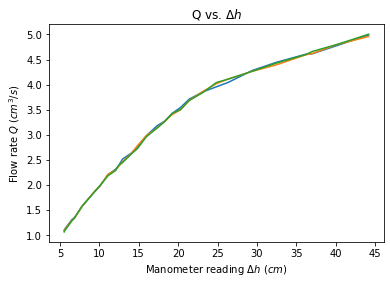

In [17]:
plt.plot(dh, Q_1)
plt.plot(dh, Q_2)
plt.plot(dh, Q_3)
plt.xlabel('Manometer reading $\Delta h$ ($cm$)')
plt.ylabel('Flow rate $Q$ ($cm^3/s$)')
plt.title('Q vs. $\Delta h$')
plt.show()

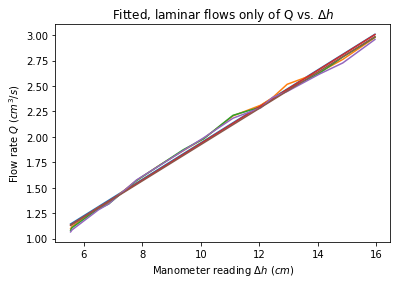

In [18]:
def line_fit(x, m, b):
    return m*x + b

x = dh[0:15]
y_1 = Q_1[0:15]
y_2 = Q_2[0:15]
y_3 = Q_3[0:15]

params_1 = curve_fit(line_fit, x, y_1)
[m_1, b_1] = params_1[0]

params_2 = curve_fit(line_fit, x, y_2)
[m_2, b_2] = params_2[0]

params_3 = curve_fit(line_fit, x, y_3)
[m_3, b_3] = params_3[0]


plt.plot(dh[0:15], line_fit(dh[0:15], m_1, b_1))
plt.plot(dh[0:15], Q_1[0:15])
plt.plot(dh[0:15], Q_2[0:15])
plt.plot(dh[0:15], line_fit(dh[0:15], m_2, b_2))
plt.plot(dh[0:15], Q_3[0:15])
plt.plot(dh[0:15], line_fit(dh[0:15], m_3, b_3))

plt.xlabel('Manometer reading $\Delta h$ ($cm$)')
plt.ylabel('Flow rate $Q$ ($cm^3/s$)')
plt.title('Fitted, laminar flows only of Q vs. $\Delta h$')
plt.show()

In [19]:
print("Fitted slopes =", m_1, m_2, m_3)    # \hat m = Q/dh = \frac{\pi R^4}{8\eta}\frac{\rho g}{dl}

Fitted slopes = 0.17946389367846158 0.18008076520985594 0.17846602223485306


In [20]:
R_pm = ufloat(0.125, 0.001)    # in cm
temp = ufloat(21, 0.5)
len_tot = ufloat(47.0, 0.01)    # total length of tube in cm

len_left_pm = abs(len_tot - unumpy.uarray(data.left, data.left_pm))   # in cm
len_right_pm = abs(len_tot - unumpy.uarray(data.right, data.right_pm))

dh_pm = len_right_pm - len_left_pm    # dh w/ uncertainty i.e. dl

rho_pm = ufloat(0.998, 0.0002)
dp_pm = rho_pm*980*dh_pm    # in g/(cm s^2) or dPa (decipascal)
rho_g_dl_pm = rho_pm*980/dh_pm    # pressure gradient w/o pressure

In [22]:
# computing eta from Eq. 5 (Eq. a) where Q/dh = \hat m (from curve_fit) i.e. using the fitted slope
def eta_hat(R, m_hat, rho, dl):
    return ((np.pi*R**4)/(8*m_hat))*((rho*980)/(dl))
# unit in g/cm s or Poise
# 0.9795 centiPoise = 0.09795 poise at 21 C from hyperphysics.phy-astr.gsu.edu/hbase/Tables/viscosity.html (density obtained from here as well)

In [23]:
# finding the average viscosity for [0: 15] since m_1 is for [0: 15]
dl_pm = dh_pm[15] - dh_pm[0]    # not the full dataset
avg_eta_hat_pm = eta_hat(R_pm, m_1, rho_pm, dl_pm)
print('The viscosity of water from linear approximation 𝜂̂ =', avg_eta_hat_pm)

The viscosity of water from linear approximation 𝜂̂ = 0.0445+/-0.0015



Alternatively, \begin{equation}\eta=\frac{\pi R^4}{8Q/8\Delta h}\frac{\rho g}{dl}\tag b\end{equation}

So we can also find $\eta$ directly from the data:

In [35]:
# including uncertainties for flow rates Q
Q_pm_1 = unumpy.uarray(data.Volume_1, 1)/unumpy.uarray(data.Time_1, 0.50)
Q_pm_2 = unumpy.uarray(data.Volume_2, 1)/unumpy.uarray(data.Time_2, 0.50)
Q_pm_3 = unumpy.uarray(data.Volume_3, 1)/unumpy.uarray(data.Time_3, 0.50)
print('A entire set of flow rates Q:\n', Q_pm_1)
print('\n and the pressure gradient 𝜌𝑔Δh:\n', dp_pm) 

# computing the viscosity w/ uncertainties numerically | from Eq. 5 (Eq. b) (the Poiseuille’s equation)
def eta(Q, R, rho_g_dl, dh):
    return (rho_g_dl*np.pi*R**4)/(8*(Q/dh))

eta_pm_1 = eta(Q_pm_1, R_pm, rho_g_dl_pm, dh_pm)    # eta( , , *, ) * is not the pressure gradient, simply (rho g)/dl
eta_pm_2 = eta(Q_pm_2, R_pm, rho_g_dl_pm, dh_pm)
eta_pm_3 = eta(Q_pm_3, R_pm, rho_g_dl_pm, dh_pm)

print('\n One set of computed viscosity of water under laminar flow 𝜂 = \n', eta_pm_1[0:15])

A entire set of flow rates Q:
 [1.096977476951803+/-0.013310114184760543
 1.1190965092402463+/-0.01176492039039053
 1.3056092843326885+/-0.014436857552020555
 1.3513513513513513+/-0.014561667511326117
 1.5701071080817917+/-0.01547397091149161
 1.722689075630252+/-0.0184848186645198
 1.864864864864865+/-0.018476636388424974
 1.9834832620557439+/-0.02076959327378455
 2.206818503324374+/-0.02106565684743051
 2.312026423159122+/-0.029697255894440076
 2.3860507800550628+/-0.023810007569130254
 2.5174825174825175+/-0.03747356899278256
 2.6343894624421504+/-0.029437239825942638
 2.761946514686541+/-0.03737435822101255
 2.977578475336323+/-0.03216965920769877
 3.17664734921657+/-0.04028557468174349
 3.2729689317162323+/-0.031862975182909314
 3.4285714285714284+/-0.051548957289238605
 3.5447154471544717+/-0.06617907672863264
 3.7094281298299845+/-0.06513515519141269
 3.8576473784297742+/-0.05902306813432919
 3.9565217391304346+/-0.04818793974519992
 4.044489383215369+/-0.057026950671393246
 4.2

The Reynolds number \begin{equation}\mathcal R=\frac{\bar v\rho R}\eta\tag c\end{equation}

where $\bar v=\frac Q{\pi R^2}$.

In [25]:
# calculate v mean from Eq. 6 (the continuity equation) | in cm/s | for finding the Reynolds number
def v_mean(R, Q):
    return Q/(np.pi*R**2)

v_mean_pm_1 = v_mean(R_pm, Q_pm_1)
v_mean_pm_2 = v_mean(R_pm, Q_pm_2)
v_mean_pm_3 = v_mean(R_pm, Q_pm_3)

In [28]:
# computing Reynolds using Eq. 8 (same as Eq. c)
def reynolds(v_mean, rho, R, eta):
    return (v_mean*rho*R)/eta

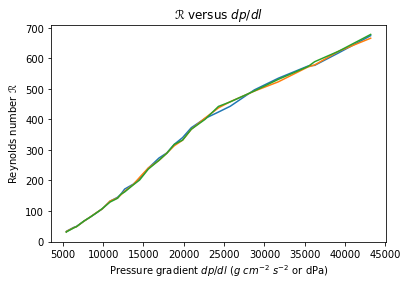

In [37]:
# Q7 plot - R versus ∆p/L | resetting variables as matplotlib won't take ufloat
R = 0.125
rho = 0.998
dp = rho*980*dh
rho_g_dl = rho*980/dh
eta_1 = eta(Q_1, R, rho_g_dl, dh)
eta_2 = eta(Q_2, R, rho_g_dl, dh)
eta_3 = eta(Q_3, R, rho_g_dl, dh)
v_mean_1 = v_mean(R, Q_1)
v_mean_2 = v_mean(R, Q_2)
v_mean_3 = v_mean(R, Q_3)
reynolds_1 = reynolds(v_mean_1, rho, R, eta_1)
reynolds_2 = reynolds(v_mean_2, rho, R, eta_2)
reynolds_3 = reynolds(v_mean_3, rho, R, eta_3)

#dp_dl = dp/47    # not this, gives nonlinear plot, plus it should be uniform

#plt.plot(Delta_p_L, reynolds_1)    # not this as well, wrong dims

plt.plot(dp, reynolds_1)
plt.plot(dp, reynolds_2)
plt.plot(dp, reynolds_3)
plt.xlabel('Pressure gradient $dp/dl$ ($g\ cm^{-2}\ s^{-2}$ or dPa)')
plt.ylabel('Reynolds number $ℛ$') # dimensionless ¿$g\ cm^{-3}$
plt.title('ℛ versus $dp/dl$')
plt.show()

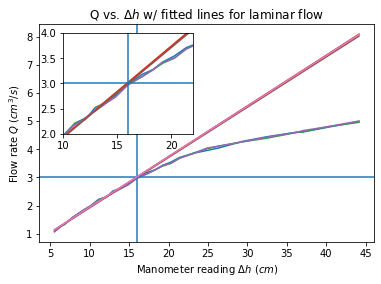

In [40]:
fig, ax = plt.subplots()

abline_values_1 = [m_1 * i + b_1 for i in dh]    # https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
abline_values_2 = [m_2 * i + b_2 for i in dh]
abline_values_3 = [m_3 * i + b_3 for i in dh]

plt.plot(dh, Q_1)
plt.plot(dh, abline_values_1)
plt.plot(dh, Q_2)
plt.plot(dh, abline_values_2)
plt.plot(dh, Q_3)
plt.plot(dh, abline_values_3)

plt.axvline(x=16)
plt.axhline(y=3)

plt.xlabel('Manometer reading $\Delta h$ ($cm$)')
plt.ylabel('Flow rate $Q$ ($cm^3/s$)')
plt.title('Q vs. $\Delta h$ w/ fitted lines for laminar flow')

# linear portin after
xb = dh[25:29]
y_1b = Q_1[25:29]
y_2b = Q_2[25:29]
y_3b = Q_3[25:29]

params_1b = curve_fit(line_fit, xb, y_1b)
[m_1b, b_1b] = params_1[0]

params_2b = curve_fit(line_fit, xb, y_2b)
[m_2b, b_2b] = params_2[0]

params_3b = curve_fit(line_fit, xb, y_3b)
[m_3b, b_3b] = params_3[0]

abline_values_1b = [m_1b * i + b_1b for i in dh]
abline_values_2b = [m_2b * i + b_2b for i in dh]
abline_values_3b = [m_3b * i + b_3b for i in dh]

plt.plot(dh, abline_values_1b)

# subplot

left, bottom, width, height = [0.18, 0.5, 0.3, 0.35]    # stackoverflow.com/questions/21001088/how-to-add-different-graphs-as-an-inset-in-another-python-graph
ax = fig.add_axes([left, bottom, width, height])

ax.plot(dh, Q_1)
ax.plot(dh, abline_values_1)
ax.plot(dh, Q_2)
ax.plot(dh, abline_values_2)
ax.plot(dh, Q_3)
ax.plot(dh, abline_values_3)

ax.axvline(x=16)
ax.axhline(y=3)

ax.set_xlim(10, 22)    # matplotlib.org/stable/gallery/subplots_axes_and_figures/zoom_inset_axes.html
ax.set_ylim(2, 4)
#axins.set_xlim(5, 18)
#axins.set_ylim(1, 3.5)
#axins.set_xticklabels('')
#axins.set_yticklabels('')

plt.show()

Thus, between the region of $\Delta h=16 - 17\rm\ cm$ and $Q=3 - 4\rm\ cm^3\ s^{-1}$, laminar flow breaks down.

In [41]:
eta_critical = eta(3.5, R, (0.998*980/dh[14]), dh[14])    # Q = 3 is approximately # 14

eta_14 = eta_1[14], eta_2[14], eta_3[14]
eta_14_mean = np.mean(eta_14)

v_mean_critical = v_mean(R, 3)

reynolds(v_mean_critical, rho, R, eta_14_mean) # ??? should near 1160

241.68659541264992